# Introduction to Data Science PC Lab 06: 
# Linear models for classification and regression

Author: Jan Verwaeren - Arne Deloose

Course: Introduction to Data Science

Welcome back!

This notebook contains Python code for the lecture on linear methods for regression and classification in the course *Introduction to data science* and includes a set of exercises as well.

<p>
Linear methods for regression and classification are key ingredients to even the most modern machine learning tools. We will see that the difference between regression methods that are over a century old (such as multiple linear regression) are still tightly linked with more modern methods (such as support vector machines).
<center><a href="https://commons.wikimedia.org/wiki/File:Svm_separating_hyperplanes.png#/media/File:Svm_separating_hyperplanes.png"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Svm_separating_hyperplanes.png/1200px-Svm_separating_hyperplanes.png" alt="Searating hyperplanes" width="200"></a> </center> </p>

## Import Libraries

To add functionality to your Python session, a series of libraries (most importantly scikit-image and scikit-learn are imported)

In [ ]:
# in Google Colab, wget is not installed by default and is installed first (if run locally, better install in terminal)
!pip install wget
!pip install loess

In [176]:
# import numpy for array manipulation
import numpy as np
# import matplotlib for visualization
import matplotlib.pyplot as plt
# import pandas
import pandas as pd

# import linear models and some convenience functions to create dummy data, plot decision boundaries ad split train and test data
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, QuantileRegressor, LogisticRegression

# import utility function to make a nice decision boundary plot
try:
    import utils_decisionBound
except:
    import wget
    URL = "https://users.ugent.be/~jverwaer/utils_decisionBound.py"
    response = wget.download(URL, "utils_decisionBound.py")
    import utils_decisionBound


In [48]:
# utility code to add lOESS smooter to plot
from loess import loess_1d

def add_loess_plot(x, y):
    x_new = np.linspace(np.min(x), np.max(x), 50)
    xout, yout, wout = loess_1d.loess_1d(x, y, x_new)
    plt.plot(xout, yout, '-')

In [107]:
# utility code to compute SE's of linear model coefficients
import statsmodels.api as sm

def print_stats_linearLS(X, y):
    X_with_intercept = np.zeros((X.shape[0], X.shape[1]+1)) + 1
    X_with_intercept[:,1:] = X
    ols = sm.OLS(y, X_with_intercept)
    ols_result = ols.fit()
    return ols_result.summary()

## 1. Linear least-squares regression

Linear least squares (LS) is thé most basic regression methods in statistics and machine learning. Provided that:
1. The link between inputs and outputs is linear
2. We want to model the average effect of X on Y, i.e. $\mathbf{E}(Y\mid X=x)$
3. The noise is Gaussian, and (preferably) identically, independently distributed or **iid**

LS is often the method of choice.



###  1.1 Preparing the data

*To illustrate the linear LS, we will use a QSAR dataset. Quantitative structure-activity relationship (QSAR) is a computational or mathematical modeling method to reveal relationships between biological activities and the structural properties of chemical compounds. The data we use contains 6 molecular descriptors of 908 different compounds. The objective is to predict the toxicity of these compounds. The target is the LC50 (the abbreviation used for the exposure concentration of a toxic substance lethal to half of the test animals) and is expressed in -LOG(mol/L).*

It is common practice (mainly for model interpretation and in some cases numerical stability) to standardize the inputs prior to analysis. 

In [8]:
# importing the iris dataset
fname = "qsar_fish_toxicity.csv"
qsar_df = pd.read_csv(fname, sep=";")

# extract X and y as two numpy arrays
X = qsar_df.iloc[:,0:6].to_numpy()  
y = qsar_df.iloc[:,6].to_numpy()

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 150, random_state=1)

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

###  1.2 Fitting a linear LS model

Fitting linear LS models follows the traditional Scikit-Learn pipeline. Recall that fitting a LS model will estimate the parameters of the model:
$$ f(\mathbf{x}) = \beta_0 +  \sum_{j = 1}^p \beta_j \, x_{j} $$
by minimizing

$$L_2(\beta) = \sum_{i=1}^n (y_i - f(\mathbf{x}_i))^2$$




In [10]:
# create model object
mdl =LinearRegression()

# fit the model
mdl.fit(X_train, y_train)

# make predictions on test set
predictions = mdl.predict(X_test)

### 1.3 Inspecting the model, its accuracy and diagnostics

Linear models can be **inspected** by means of their estimated coefficients. For standardized data, the size and sign of a coefficient provides information on the importance of its associated value in the model. However, when variables are highly correlated, it should be noted that:
- their associated coefficients are hard to estimate accurately
- the interpretation of a coefficient as the size of the effect of a unit increase of its associated input on the target variable (keeping the other variables constant) remains valid, but when variables are strongly correlated, such a unit increase often does not represent a realistic scenario  

In [ ]:
# get model coefficients
print("Coefficients:", mdl.coef_)
# get model interspect
print("Intercept:", mdl.intercept_)
# inspect correlations
print("Correlation matrix:")
print(np.corrcoef(X_train.T))

Estimates of the Standard Errors (and confidence intervals) are not available by default in sklearn. As an alternative, we use a utility function defined above.

In [ ]:
print_stats_linearLS(X_train, y_train)

The **performance on the test data** can be computed quite easily by implementing 

$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - f(\mathbf{x}_i))^2}\,, \qquad \text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - f(\mathbf{x}_i)|\,, \qquad \text{MRAE} = \frac{1}{n} \sum_{i=1}^n \left|\frac{y_i - f(\mathbf{x}_i)}{y_i}\right| $$

In [ ]:
RMSE = np.sqrt(np.mean((y_test - predictions)**2))
MAE = np.mean(np.abs(y_test - predictions))
MRAE = np.mean(np.abs((y_test - predictions)/y_test))
print("MSE:", RMSE, "MAE:", MAE, "MRAE:", MRAE)

Lastly, the adequcay of the model is most often assessed using diagnostic plots.
- Plot predicted versus observed
- Plot fitted versus residuals
- Plot input versus residuals
- Histogram of residuals

In [ ]:
# compute residuals
resid = y_test - predictions

# observed versus predicted
fig = plt.figure()
plt.subplot(2, 2, 1)
plt.plot(y_test, predictions, '*')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)]) # add first bisector

# predicted versus residuals
plt.subplot(2, 2, 2)
plt.plot(predictions, resid, '*')
add_loess_plot(predictions, resid)    

# predicted versus residuals
plt.subplot(2, 2, 3)
plt.plot(X_test[:,0], resid, '*')
add_loess_plot(X_test[:,0], resid)

plt.subplot(2, 2, 4)
plt.hist(resid)

fig.set_figwidth(10)

**EXERCISE:** The dataset ``polynomial.csv`` contains three inputs (x1, x2 and x3) and one output variable (y). Train a linear regression model $f(x) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3$ and inspect:
- The accuracy of this model on a test set
- If the assumption of linearity holds for this model

In [ ]:
# read the data
fname = "polynomial.csv"
polynomial_df = pd.read_csv(fname)

# extract labels/features and create train and test set
# ...

# fit the linear model 
# ...

# compute the performance of the model (MAE)
# ...

# create dagnostic plots
# ...

## 2. Polynomial regression

Polynomial regression allows to extend linear regression models with higher-order components such as $x^2$, $x^3$, $x_1 x_2$, etc. Consider the model:

$$f(x) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_{1,1} x_1^2 + \beta_{1,2} x_1 x_2 $$

**EXERCISE:** Consider the dataset ``plynomial.csv`` which contains three inputs (x1, x2 and x3) and one output variable (y). Fit the model specified above to that dataset by builinng on the ingredients introduced in Section 1.

In [ ]:
# read the data
fname = "polynomial.csv"
polynomial_df = pd.read_csv(fname)

# extract labels/features and create train and test set
# ...

# extend the feature matrix by including polynomial features
# ...

# fit a model
# ...

# compute the model performance
# ...

# inspect the coefficients
mdl.coef_

The general form a polynomial regression model of order $3$ is:

$$ f(x) = \beta_0 + \sum_{i = 1}^{p} \beta_{i} x_i + \sum_{i = 1}^{p} \sum_{j = 1}^{p} \beta_{i, j} x_i x_j + \sum_{i = 1}^{p} \sum_{j = 1}^{p} \sum_{\ell = 1}^{p} \beta_{i, j, \ell} x_i x_j x_{\ell} $$

and can be extended to models of order $k > 3$ by addeding higher order terms. Linear regression models can be used here as well, yet after extending the input matrix $X$ with columns that represent the higer-order inputs. As this is a general task, Scikit-learn provedes a convenient function to exted $X$. In the example below, the QSAR dataset is modeled using a polynomial model of order 2.

In [101]:
# create a model (note the similarity with the standard scaler - which is also part of the preprocessing submodule)
# (NOTE: class also adds a constant column (filled with ones),
# this column allows you to include an intercept (beta_0) in a model and estimate its value in the same way
# the remaining parameters are estimated. HOWEVER, most fit methods already estimate the value of the intercept 
# as a default setting -> avoid models with 'two' intercepts (will raise errors) by eiter setting fit_intercept = False
# when calling the .fit method on the regressor/classifier object or by setting include_bias = False which prevents the
# constant column from being added)
transformer = PolynomialFeatures(degree = 2, include_bias = False)

# estimate its parameters (quite simple here as there are no parameters to estimate, scikit only computs how many outputs there should be)
transformer.fit(X_train)

# compute additional features (NOTE: when include_bias is set to True when creating the transoformer object,
# an extra column with ones will appear in X_train_extended)
X_train_extended = transformer.transform(X_train) 

**EXERCISE**: Compute the accuracy of the polynomial model of order $k = 2$ on the training test set (and compare with the linear model). Is this model better, and why? 

In [ ]:
# fit model

# ....

# compute performance on test set

# ...

## 3. Loss functions

Linear regression models typically use the $L_2$ loss function. However, $L_2$ loss is rather strongly influenced by the presence of outliers. To mitigate the effect of outliers, robust alternatives are sometimes used. A simple example of a robust alternative is the $L_1$ loss function, which uses the absolute value of the residuals as opposed to its square.

$$ L_1(\beta) = \sum_{i= 1}^n \left| y_i - f(\mathbf{x}_i) \right| $$

Interestingly, when minimizing the $L_1$  loss, the resulting model will estimate the median of Y given X (as opposed to the mean of Y given X for L2-loss). The median is also known as the 0.5th quantile. Therfore, it can be found in the module ``QuantileRegressor``.

In [103]:
# create model
mdl = QuantileRegressor(alpha = 0.00001)   # information on alpha will follow in the next classes
                                           # for now, it is important to make it very small (such 
                                           # its effect is neglegible)
# fit model
# fit the model
mdl.fit(X_train, y_train)

# make predictions on test set
predictions = mdl.predict(X_test)

# compute accuracy
RMSE = np.sqrt(np.mean((y_test - predictions)**2))
MAE = np.mean(np.abs(y_test - predictions))
MRAE = np.mean(np.abs((y_test - predictions)/y_test))
print("MSE:", RMSE, "MAE:", MAE, "MRAE:", MRAE)

MSE: 1.0692650866033386 MAE: 0.718420028478148 MRAE: 0.22686262535577523


## 4. Logistic regression

Logistic regression is a basic (linear) binary classification method. This method models the probability that an instance belongs to the positive class as a linear function of the features. In case of one input the model is:

$$ P(Y = 1 \mid x) = \frac{1}{1+e^{-f(x)}} = \frac{1}{1+e^{-(\beta_0 + \beta_1 x)}}\,,$$

and its parameters $\beta_0$ and  $\beta_1$ are estimated using maximum likelihood. In the case of more than one input ($p > 1$) the linear component is simply extended by adding more inputs:  $\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots +\beta_p x_p$.

**STEP 1: Read and preprocess the data**

In [186]:
# read the data
fname = "heart_disease.csv"
heart_df = pd.read_csv(fname, sep = " ")

# extract X and y as two numpy arrays
X = heart_df["age"].to_numpy().reshape(-1, 1) 
y = heart_df["has_heart_disease"].to_numpy()

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 100, random_state=1)

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**STEP 2: Build model**

In [187]:
# create model object
mdl = LogisticRegression(penalty = 'none')

# fit model on training data
mdl.fit(X_train, y_train)

# predict on test data
predictions = mdl.predict(X_test)

**STEP 3: compute accuracy**

In [ ]:
# accuracy
np.sum(y_test == predictions)/len(predictions)

**STEP 4: model diagnostics**

In [ ]:
# get predicted probabilities and 0/1 version of the labels
predictions_prob = mdl.predict_proba(X_test)
labels_0_1 = np.zeros(len(y_test))
labels_0_1[y_test=="yes"] = 1

# plot predicted probabilities versus labels
plt.plot(predictions_prob[:,1], labels_0_1, 'o')
add_loess_plot(predictions_prob[:,1], labels_0_1)

**EXERCISE (a)**: use the entire heart disease dataset to build a logistic regression model and check its accuracy

In [200]:
# complete ...

**EXERCISE (b)**: some variables might not be relevant to use as inputs (as they are not related to the output). Find and implement a simple strategy that can eliminate such variables from the model and rebuild the model only containing the most relevant variables. Also compute its accuracy.

In [201]:
# complete ...

## 4. Multinomial regression

Multinomial regression is a basic (linear) multi-class classification method and an extension of logistic regression. This method models the probability that an instance belongs to the positive class as a linear function of the features. For $K$ classes the model is:

$$ P(Y = k \mid \mathbf{x}) = \frac{e^{f_k(\mathbf{x})}}{1+ \sum_{j = 1}^{K-1}e^{f_j(\mathbf{x})}} \,, \text{if } k < K$$
$$ P(Y = k \mid \mathbf{x}) = \frac{1}{1+ \sum_{j = 1}^{K-1}e^{f_j(\mathbf{x})}} \,, \text{if } k = K$$

and is fit using maximum likelihood.

**STEP 1: Load the data**

In [203]:
# load the iris dataset
url='https://raw.githubusercontent.com/jverwaer/IntroDataScience/main/PCLabs/files_IDS/iris.csv'
iris_df = pd.read_csv(url,
                      sep = ';',
                      header = 0)
X = iris_df.iloc[:, :2].to_numpy()
Y = iris_df.iloc[:, 4].to_numpy()

**STEP 2: fit a model**

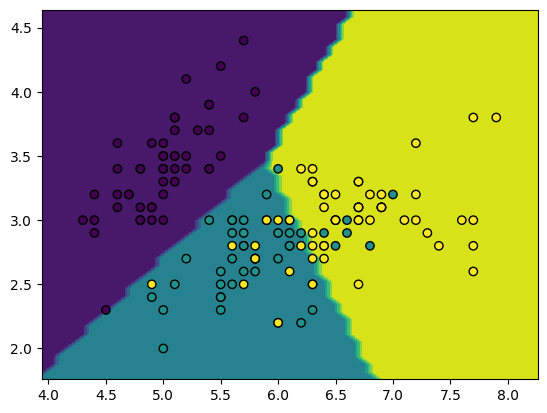

In [205]:
# create multinomial logistic regression model
mdl = LogisticRegression()
mdl.fit(X, Y)

# show decision boundary
utils_decisionBound.plotDecisionBound(X, Y, mdl)

**STEP 3: compute the accuracy (in this case on the training data)**

In [209]:
# create predictions
predictions = mdl.predict(X)
# compute accuracy
np.sum(predictions == Y)/len(Y)

0.82